In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import confusion_matrix

from utils import * 
from model import * 

/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import os 
print("Current working directory: ", os.getcwd())

# Ground Truth Dataset 
data = np.load('./CompressedDatasets/cifar10/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

Current working directory:  /home/jk2338/distilled-image-dataset


U shape: torch.Size([50000, 1000]), sigma shape: torch.Size([3072]), V shape: torch.Size([3072, 3072])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


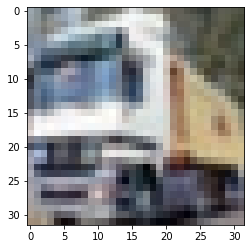

In [4]:
# Sanity check for reconstructing images
k = 1000
U, sigma, V = prepare_dataset(k)
print(f"U shape: {U.shape}, sigma shape: {sigma.shape}, V shape: {V.shape}")

reconstructed_img = reconstruct_img(U[1], sigma[:k], V[:k, :])

reconstructed_img = reconstructed_img.flatten()
U_test = (reconstructed_img @ torch.inverse(V)) @ torch.inverse(torch.diag(sigma))
new_img = U_test @ torch.diag(sigma) @ V
new_img = new_img.reshape(3, 32, 32)
new_img = new_img.permute(1, 2, 0)
plt.imshow(new_img)

In [5]:
def validate(model, test_loader): 
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_test_tensor, y_test_tensor in test_loader:
            X_test_tensor = X_test_tensor.to(device)
            y_test_tensor = y_test_tensor.to(device)

            y_test_tensor = y_test_tensor.flatten()
            outputs = model(X_test_tensor)
            _, predicted = outputs.max(1)
            correct += (predicted == y_test_tensor).sum().item()  # Accumulate correct predictions
            total += y_test_tensor.size(0)  # Accumulate total samples


    accuracy = 100. * correct / total  # Calculate overall accuracy
    # print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [6]:
def train(model, train_loader, test_loader, optimizer, epochs, criterion, experiment_name = None): 
    train_accuracy = [] 
    val_accuracy = []

    # Training loop
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0 

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        val_acc = validate(model, test_loader)
        val_accuracy.append(val_acc)

        train_accuracy.append(correct / total)


    # Save the model
    if experiment_name is not None:
        torch.save(model.state_dict(), f"./results/cifar-model/{experiment_name}.pth")
        print(f"Model saved as {experiment_name}.pth")
    else: 
        torch.save(model.state_dict(), f"./results/cifar-model/{experiment_name}.pth")
        print(f"Model saved as {experiment_name}.pth")

    return max(val_accuracy)

In [8]:
import warnings 
warnings.filterwarnings("ignore")

data = np.load('./CompressedDatasets/cifar10/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

singular_values = [] 
accuracies = [] 

for k in range(200, 3072, 100):  
    U, sigma, V = prepare_dataset(k)
    U = torch.tensor(U, dtype=torch.float32, device=device)
    sigma = torch.tensor(sigma, dtype=torch.float32, device=device)
    V = torch.tensor(V, dtype=torch.float32, device=device)
    
    # Define training parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(sigma, V).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    batch_size = 64
    epochs = 25

    # Create DataLoader
    train_dataset = TensorDataset(torch.tensor(U, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Train the model
    experiment_name = f"model_{k}"
    acc = train(model, train_loader, test_loader, optimizer, epochs, criterion, experiment_name)
    
    accuracies.append(acc)
    singular_values.append(k)

100%|██████████| 25/25 [01:30<00:00,  3.63s/it]


Model saved as model_200.pth


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


Model saved as model_300.pth


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


Model saved as model_400.pth


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


Model saved as model_500.pth


100%|██████████| 25/25 [01:15<00:00,  3.03s/it]


Model saved as model_600.pth


100%|██████████| 25/25 [01:15<00:00,  3.04s/it]


Model saved as model_700.pth


100%|██████████| 25/25 [01:17<00:00,  3.10s/it]


Model saved as model_800.pth


100%|██████████| 25/25 [01:21<00:00,  3.27s/it]


Model saved as model_900.pth


100%|██████████| 25/25 [01:22<00:00,  3.32s/it]


Model saved as model_1000.pth


100%|██████████| 25/25 [01:25<00:00,  3.41s/it]


Model saved as model_1100.pth


100%|██████████| 25/25 [01:30<00:00,  3.61s/it]


Model saved as model_1200.pth


100%|██████████| 25/25 [01:32<00:00,  3.68s/it]


Model saved as model_1300.pth


100%|██████████| 25/25 [01:34<00:00,  3.76s/it]


Model saved as model_1400.pth


100%|██████████| 25/25 [01:40<00:00,  4.02s/it]


Model saved as model_1500.pth


100%|██████████| 25/25 [01:44<00:00,  4.19s/it]


Model saved as model_1600.pth


100%|██████████| 25/25 [01:48<00:00,  4.35s/it]


Model saved as model_1700.pth


100%|██████████| 25/25 [01:56<00:00,  4.67s/it]


Model saved as model_1800.pth


100%|██████████| 25/25 [02:00<00:00,  4.81s/it]


Model saved as model_1900.pth


100%|██████████| 25/25 [02:03<00:00,  4.95s/it]


Model saved as model_2000.pth


100%|██████████| 25/25 [02:13<00:00,  5.33s/it]


Model saved as model_2100.pth


100%|██████████| 25/25 [02:18<00:00,  5.53s/it]


Model saved as model_2200.pth


100%|██████████| 25/25 [02:21<00:00,  5.67s/it]


Model saved as model_2300.pth


100%|██████████| 25/25 [02:32<00:00,  6.09s/it]


Model saved as model_2400.pth


100%|██████████| 25/25 [02:38<00:00,  6.34s/it]


Model saved as model_2500.pth


100%|██████████| 25/25 [02:48<00:00,  6.72s/it]


Model saved as model_2600.pth


100%|██████████| 25/25 [02:57<00:00,  7.08s/it]


Model saved as model_2700.pth


100%|██████████| 25/25 [03:01<00:00,  7.26s/it]


Model saved as model_2800.pth


100%|██████████| 25/25 [03:10<00:00,  7.64s/it]


Model saved as model_2900.pth


100%|██████████| 25/25 [03:21<00:00,  8.05s/it]

Model saved as model_3000.pth


In [ ]:
np.savez('./results/accuracy_cifar10.npz', accuracies=accuracies, singular_values=singular_values)

Text(0, 0.5, 'Test Accuracy (%)')

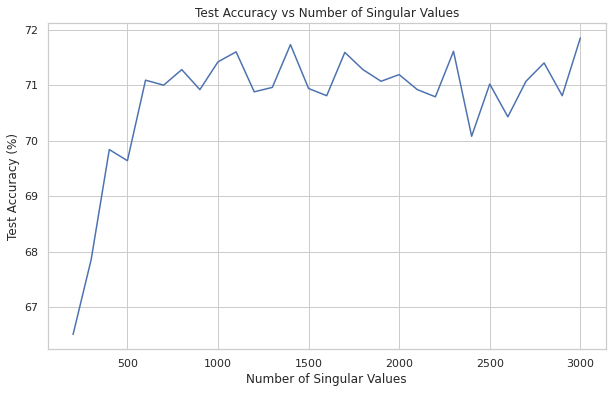

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(singular_values, accuracies, color='b')


plt.title("Test Accuracy vs Number of Singular Values")
plt.xlabel("Number of Singular Values")
plt.ylabel("Test Accuracy (%)")
